01_eda_regimes.ipynb
  ---
## AI-Driven Volatility Forecasting & Adaptive Portfolio Optimization
  Notebook 01: Exploratory Data Analysis — Volatility Regimes
 ---
## Purpose
 This notebook explores volatility regimes using VIX data, regime detection logic
from `src/features/regimes.py`, and regime-conditioned return distributions.

Audience Fit:
 - **Quant recruiters** → See rigorous methodology, clean plots, reproducibility
 - **Portfolio managers** → Understand regime behavior, tail risks, transition dynamics
 - **Executives** → Clear story of how volatility regimes matter for allocation

## Notebook Sections
 1. Setup & Imports
 2. Load Market Data (SPY + VIX as baseline)
 3. Apply Regime Detector (from regimes.py)
 4. Visualize Regimes on Price & Volatility
 5. Regime Statistics (mean returns, vol, drawdowns)
 6. Transition Analysis
 7. Save Outputs (figures + regime features parquet)

 -------------------
## 1. Setup & Imports
 -------------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Import the correct settings instance
from src.config.settings import settings

# Import other modules
from src.features.regimes import RegimeDetector, VolatilityRegime
from src.data.fetchers import get_yfinance_data

# Patch the RegimeDetector if needed
original_init = RegimeDetector.__init__
def patched_init(self):
    self.thresholds = settings.VIX_THRESHOLDS
    self.hysteresis = 0.9
    self.current_regime = None
RegimeDetector.__init__ = patched_init

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12,6)

# Output paths
OUTPUT_DIR = Path("reports/eda")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Verify settings is working
print("VIX Thresholds:", settings.VIX_THRESHOLDS)

VIX Thresholds: {'low': 15, 'medium': 25, 'high': 30, 'extreme': 40}


 --------------------------
## 2. Load Market Data (SPY)
 --------------------------

In [2]:
# Load market data
tickers = ["SPY", "^VIX"]
df = get_yfinance_data(tickers, start="2015-01-01", end="2025-01-01")

# Debug: see what we got
print("Original columns:", df.columns.tolist())

# Handle multi-level columns
if isinstance(df.columns, pd.MultiIndex):
    # Flatten the columns
    new_columns = []
    for col in df.columns:
        if col[0] == '^VIX':
            new_columns.append(f"VIX_{col[1]}")
        else:
            new_columns.append(f"{col[0]}_{col[1]}")
    df.columns = new_columns
    print("Flattened columns:", df.columns.tolist())

# Find the VIX close column
vix_close_col = None
for col in df.columns:
    if col.startswith('VIX_') and ('Close' in col or 'Adj' in col):
        vix_close_col = col
        break

if not vix_close_col:
    # Try other common patterns
    for col in df.columns:
        if 'VIX' in col and ('Close' in col or 'Adj' in col):
            vix_close_col = col
            break

if vix_close_col:
    print(f"Using VIX column: {vix_close_col}")
    
    # Apply regime detection
    detector = RegimeDetector()
    regimes = detector.detect_regimes(df[vix_close_col])
    df["regime"] = regimes.values
    
    # Add one-hot regime features
    features = detector.create_regime_features(df[[vix_close_col]])
    df = pd.concat([df, features], axis=1)
    
else:
    print("ERROR: Could not find VIX data. Available columns:", df.columns.tolist())

Original columns: ['SPY', '^VIX']
ERROR: Could not find VIX data. Available columns: ['SPY', '^VIX']


 ---------------------------
## 3. Apply Regime Detection
 ---------------------------

In [3]:
# Apply regime detection
df = df.rename(columns={"^VIX": "VIX"})

# Now you can use the simpler column names
detector = RegimeDetector()
regimes = detector.detect_regimes(df["VIX"])
df["regime"] = regimes.values

# Add one-hot regime features
features = detector.create_regime_features(df[["VIX"]])
df = pd.concat([df, features], axis=1)


 ------------------------------
## 4. Visualize Regime Dynamics
 ------------------------------

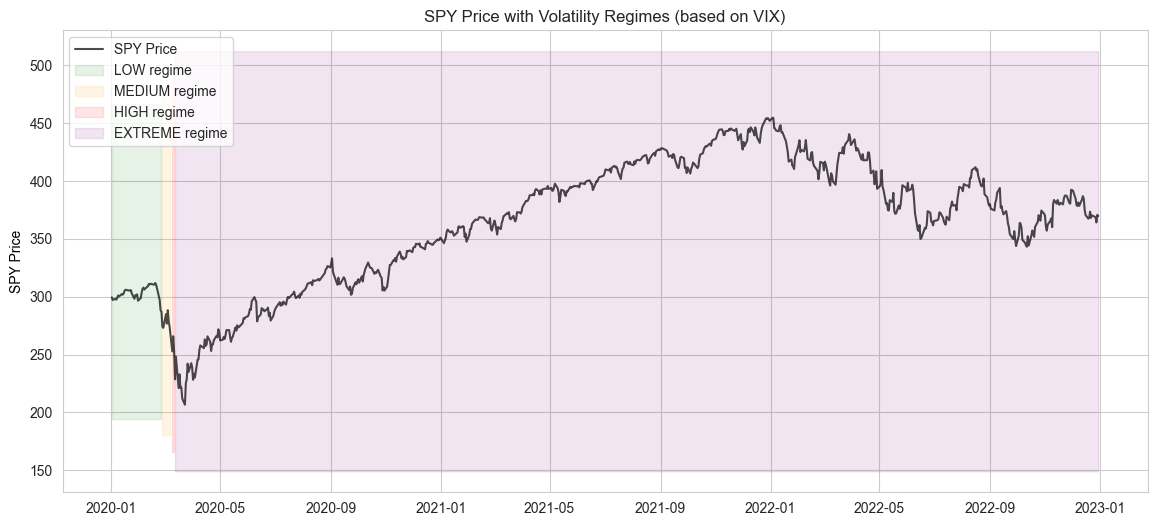

In [4]:
fig, ax1 = plt.subplots(figsize=(14,6))

ax1.plot(df.index, df["SPY"], color="black", alpha=0.7, label="SPY Price")
ax1.set_ylabel("SPY Price", color="black")

# Regimes shading
regime_colors = {
    VolatilityRegime.LOW: "green",
    VolatilityRegime.MEDIUM: "orange",
    VolatilityRegime.HIGH: "red",
    VolatilityRegime.EXTREME: "purple"
}
for regime, color in regime_colors.items():
    mask = df["regime"] == regime
    ax1.fill_between(df.index, ax1.get_ylim()[0], ax1.get_ylim()[1],
                     where=mask, color=color, alpha=0.1, label=f"{regime.name} regime")

ax1.legend(loc="upper left")
plt.title("SPY Price with Volatility Regimes (based on VIX)")
plt.savefig(OUTPUT_DIR / "regime_price_overlay.png")
plt.show()

 ----------------------------
## 5. Regime-Conditioned Stats
 ----------------------------

In [5]:
# Ensure returns column exists and calculate if missing
if 'returns' not in df.columns:
    df["returns"] = df["SPY"].pct_change()
    df = df.dropna()  # Remove rows with NaN returns

# Convert regime enum to sortable values
df["regime_code"] = df["regime"].apply(lambda x: x.value)
df["regime_name"] = df["regime"].apply(lambda x: x.name)

# Now calculate summary statistics
summary_stats = (
    df.groupby("regime_code")["returns"]
    .agg(["mean", "std", "count"])
    .rename(columns={"mean": "avg_return", "std": "volatility"})
)
summary_stats["sharpe_proxy"] = summary_stats["avg_return"] / summary_stats["volatility"]

# Add regime names for better readability
regime_mapping = {
    VolatilityRegime.LOW.value: "LOW",
    VolatilityRegime.MEDIUM.value: "MEDIUM", 
    VolatilityRegime.HIGH.value: "HIGH",
    VolatilityRegime.EXTREME.value: "EXTREME"
}
summary_stats["regime_name"] = summary_stats.index.map(regime_mapping)

print("Regime-Conditioned Return Statistics:")
display(summary_stats)

# Save to CSV
summary_stats.to_csv(OUTPUT_DIR / "regime_stats.csv")

Regime-Conditioned Return Statistics:


,avg_return,volatility,count,sharpe_proxy,regime_name
regime_code,,,,,
1,-0.002726,0.013161,18,-0.207167,LOW
2,-0.006026,0.035639,7,-0.169072,MEDIUM
3,-0.025033,0.068091,3,-0.367635,HIGH
4,0.000653,0.015230,708,0.042887,EXTREME


 -----------------------
## 6. Transition Analysis
 -----------------------


Regime Transition Counts:


VolatilityRegime.LOW        1
VolatilityRegime.MEDIUM     1
VolatilityRegime.HIGH       1
VolatilityRegime.EXTREME    1
Name: regime, dtype: int64

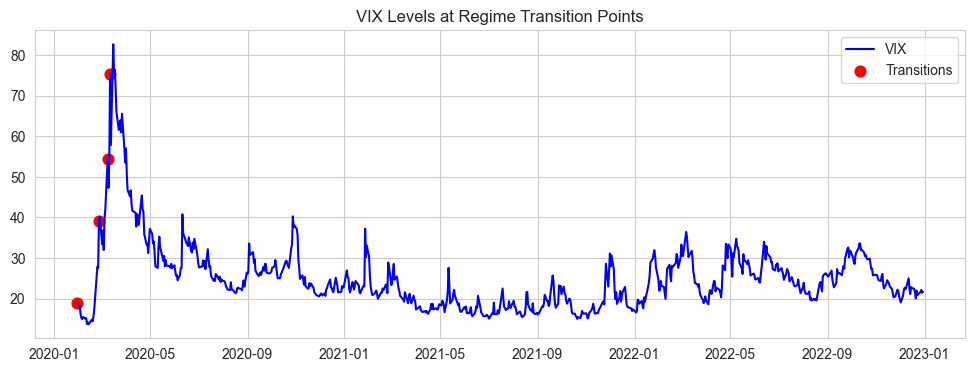

In [6]:
df["regime_shift"] = df["regime"] != df["regime"].shift(1)
transition_counts = df.loc[df["regime_shift"], "regime"].value_counts()

print("Regime Transition Counts:")
display(transition_counts)

# Plot transition points
plt.figure(figsize=(12,4))
plt.plot(df.index, df["VIX"], label="VIX", color="blue")
plt.scatter(df.loc[df["regime_shift"]].index,
            df.loc[df["regime_shift"], "VIX"],
            color="red", marker="o", s=60, label="Transitions")
plt.legend()
plt.title("VIX Levels at Regime Transition Points")
plt.savefig(OUTPUT_DIR / "regime_transitions.png")
plt.show()


 -----------------------
## 7. Save Outputs
 -----------------------

In [7]:
# Prepare data for saving - convert all enum columns to serializable formats
df_save = df[["SPY","VIX","regime"] + list(features.columns)].copy()

# Convert regime enum to numeric values
df_save["regime"] = df_save["regime"].apply(lambda x: x.value)

# Also check if any other columns contain enum values and convert them
for col in df_save.columns:
    if df_save[col].dtype == 'object' and df_save[col].notna().any():
        sample_val = df_save[col].dropna().iloc[0]
        if hasattr(sample_val, 'value'):  # Check if it's an enum
            df_save[col] = df_save[col].apply(lambda x: x.value if hasattr(x, 'value') else x)

# Save to parquet
features_path = OUTPUT_DIR / "regime_features.parquet"
df_save.to_parquet(features_path)

print(f"EDA regime analysis complete. Outputs saved to {OUTPUT_DIR}")

EDA regime analysis complete. Outputs saved to reports\eda
